### 0. Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# set gpu
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# set the random seed
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

### 1. Training with simulated data ONLY

In [5]:
from data_gen import create_batch_noisy
from models.model_log_sig import RecSpectrometer

num_d = 16
model = RecSpectrometer(num_sensors=num_d, num_wavelengths=301).to(device)

In [6]:
from utils import normalize_y, log_min_max_mapping, log_min_max_mapping_safe, max_normalize, min_max_scaling
nmlz_func = log_min_max_mapping

from params import batch_size, learning_rate, num_iters
# batch_size = 256
# learning_rate = 0.0003
# num_iters = 20000

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
criterion = nn.MSELoss(reduction='mean')

In [7]:
model.train()
loss_vals = []
for i in tqdm(range(num_iters)):
    optimizer.zero_grad()

    # noiseless training    
    X_spec, X_pk, y = create_batch_noisy(batch_size, min_dist=10, add_base=False, width_decay=False)

    # # noiseless trial
    # X_spec, X_pk, y = create_batch_noiseless(batch_size)
    
    X_spec, X_pk, y = X_spec.to(device), X_pk.to(device), y.to(device)


    y_ = normalize_y(y, func=nmlz_func)
    y_ = y_[:,-num_d:]
    X_pred = model(y_)
    loss = criterion(X_pred, X_spec)
    # loss = weighted_mse_loss(X_pred, X_spec, weight=weight_temp)
    
    loss.backward()
    optimizer.step()
    # scheduler.step()

    # break
    loss_vals.append(loss.item())
    clear_output(wait=True)
    display(f'Iteration: {i}, Loss: {loss.item():0.3e}')

'Iteration: 19999, Loss: 5.502e-03'

100%|██████████| 20000/20000 [19:20<00:00, 17.24it/s]


The current training loss is 5.502e-03.


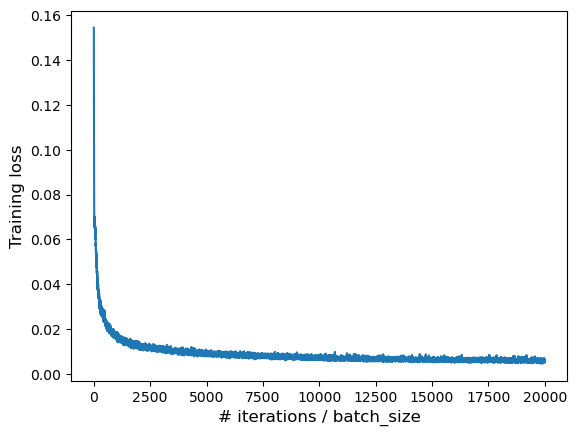

In [10]:
%matplotlib inline
plt.plot(loss_vals)
plt.xlabel("# iterations / batch_size", size=12)
plt.ylabel("Training loss", size=12)
print("The current training loss is {0:.3e}.".format(loss_vals[-1]))